In [2]:
#Importing tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [3]:
#Loading data
data=pd.read_csv('train.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13741 entries, 0 to 13740
Data columns (total 12 columns):
age                 13741 non-null int64
speciality_years    13741 non-null int64
speciality          13741 non-null object
wing                13741 non-null object
entry_level         13741 non-null object
occupation          13741 non-null object
intervention        13741 non-null object
ethnicity           13741 non-null object
 sex                13741 non-null object
hours               13741 non-null int64
country             13741 non-null object
target              13741 non-null int64
dtypes: int64(4), object(8)
memory usage: 1.3+ MB


In [424]:
data.describe()

,age,speciality_years,hours,target
count,13741.000000,13741.000000,13741.000000,13741.000000
mean,43.220508,12.032385,45.465759,0.399461
std,14.554970,3.150086,13.465993,0.489806
min,18.000000,1.000000,1.000000,0.000000
25%,33.000000,10.000000,44.000000,0.000000
50%,42.000000,12.000000,44.000000,0.000000
75%,53.000000,15.000000,52.000000,1.000000
max,99.000000,19.000000,108.000000,1.000000


# EDA

target
0    8252
1    5489
dtype: int64


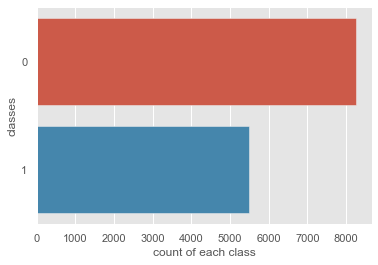

In [425]:
print(data.groupby('target').size())
plt.style.use('ggplot')

#Visualize Class Counts
sns.countplot(y=data.target ,data=data)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()
#the data does seem to be imbalanced

In [426]:
#Function for outlier detection (Tukey's method)

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers  
# detect outliers from age, speciality_years and hours
Outliers_to_drop = detect_outliers(data,2,['age', 'speciality_years', 'hours'])


In [427]:
data.loc[Outliers_to_drop]
#we notice that there are no outliers to drop if we set n=2

,age,speciality_years,speciality,wing,entry_level,occupation,intervention,ethnicity,sex,hours,country,target


In [428]:
# Check for Null values
data.isnull().sum()

age                 0
speciality_years    0
speciality          0
wing                0
entry_level         0
occupation          0
intervention        0
ethnicity           0
 sex                0
hours               0
country             0
target              0
dtype: int64

Let's analyze the variables one by one.

In [429]:
print(data['intervention'].value_counts(dropna=False))

Therapeutic     6553
Other           3169
Anesthesia      1646
Diagnostic      1258
Surgical         798
Propaedeutic     317
Name: intervention, dtype: int64


In [430]:
print(data['entry_level'].value_counts(dropna=False))

minor-medium    7582
minor           3738
high            1704
medium-high      363
medium           354
Name: entry_level, dtype: int64


In [431]:
print(data['ethnicity'].value_counts(dropna=False))

 White                 11909
 Black                  1172
 Asian-Pac-Islander      460
 Amer-Indian-Eskimo      116
 Other                    84
Name: ethnicity, dtype: int64


In [432]:
print(data['speciality'].value_counts(dropna=False))

Psychiatry            4163
Emergency             2891
Pulmonary             2645
Pediatrics             936
Opthalmology           571
Gynecology/Urology     467
Orthopedic             439
Neurosciences          345
Nephrology             300
Endocrinology          259
Oncology               215
Radiology              177
Gastroenterology       137
Anaesthesiology        129
Cardiology              51
Aesthetic               16
Name: speciality, dtype: int64


In [433]:
print(data['speciality_years'].value_counts(dropna=False))

10    4163
12    2891
15    2645
16     936
13     571
14     467
8      439
18     345
7      300
19     259
4      215
6      177
9      137
3      129
2       51
1       16
Name: speciality_years, dtype: int64


In [434]:
print(data['country'].value_counts(dropna=False))

 United-States                 12375
 ?                               239
 Mexico                          219
 Philippines                      95
 Germany                          63
 Canada                           55
 India                            49
 Puerto-Rico                      46
 England                          39
 China                            38
 El-Salvador                      37
 South                            33
 Cuba                             32
 Japan                            32
 Italy                            32
 Vietnam                          31
 Jamaica                          30
 Iran                             25
 Taiwan                           24
 Guatemala                        21
 Columbia                         21
 Haiti                            19
 Poland                           17
 Nicaragua                        16
 Dominican-Republic               13
 Peru                             13
 Portugal                         12
 

In [435]:
print(data['occupation'].value_counts(dropna=False))

Patient               3781
Dietitian             2075
Therapist             1622
Medical Assistants    1439
Techs                 1110
Nurse                  765
 ?                     711
Surgeons               624
ER doctors             475
Lab                    415
Physician              374
Gift Shop              293
Cafeteria               54
Delivery                 3
Name: occupation, dtype: int64


In [436]:
print(data['wing'].value_counts(dropna=False))

W     9300
SW    1142
S      903
 ?     711
SE     619
NW     586
N      474
NE       6
Name: wing, dtype: int64


## Numerical variables

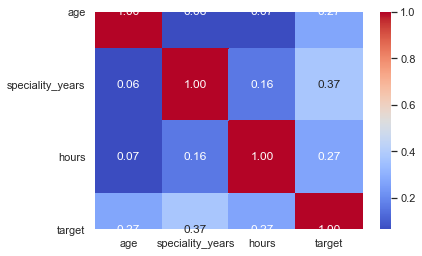

In [356]:
#heatmap for numerical variables
g = sns.heatmap(data.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
#there appears to be small correlations between the variables

### Age

C:\Users\Beatrice\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Beatrice\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


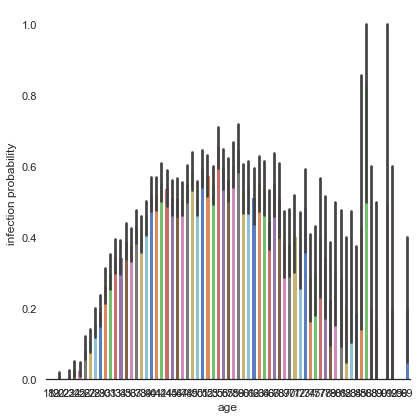

In [357]:
# Explore age feature vs target
g = sns.factorplot(x="age",y="target",data=data,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("infection probability")

#not a very readable graph because there are a lot of possible values

In [437]:
#binning the numerical variables
data['age_bins'] = pd.cut(x=data['age'], bins=[10,19, 29, 39, 49,59,69,79,89,99])
data['hours_bins'] = pd.cut(x=data['hours'], bins=[0,11,23,35,47,59,71,83,95,110])
data['years_bins'] = pd.cut(x=data['speciality_years'], bins=[0,4,9,14,19])

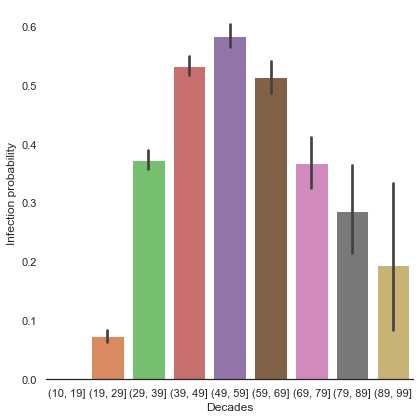

In [359]:
#AGE
# Explore age feature vs target
g = sns.factorplot(x="age_bins",y="target",data=data,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Infection probability")
g = g.set_xlabels("Decades")

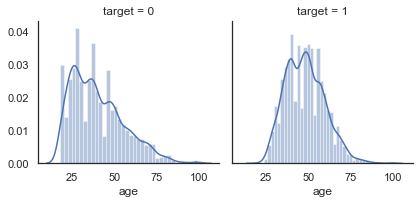

In [360]:
g = sns.FacetGrid(data, col='target')
g = g.map(sns.distplot, "age")
#Age distribution seems to be a tailed distribution.
#We notice that age distributions are not the same in the infected and not infected subpopulations.
#It seems that younger patients have a lower probability to contract the virus.

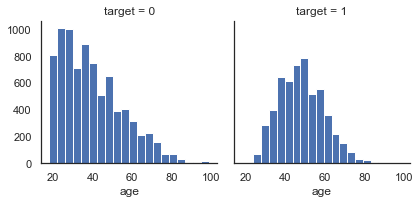

In [361]:
g = sns.FacetGrid(data, col='target')
g.map(plt.hist, 'age', bins=20)

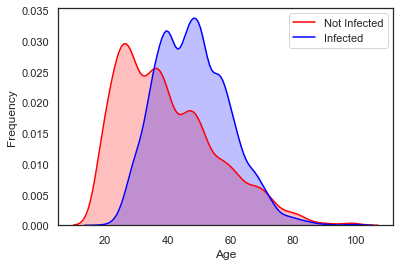

In [362]:
# further exploration of Age distibution 
g = sns.kdeplot(data["age"][(data["target"] == 0) & (data["age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(data["age"][(data["target"] == 1) & (data["age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Infected","Infected"])

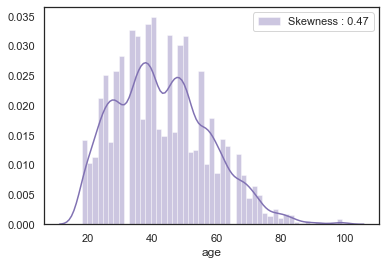

In [363]:
#let's compute skewness of the age feature
g = sns.distplot(data["age"], color="m", label="Skewness : %.2f"%(data["age"].skew()))
g = g.legend(loc="best")
#there seems to be an important skewness

### Speciality years

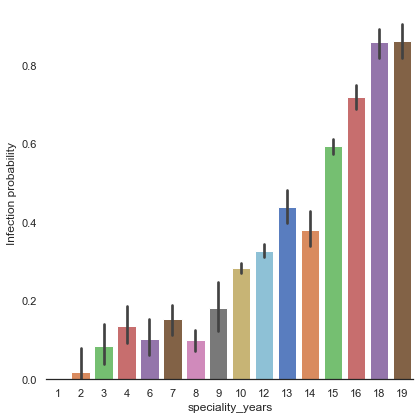

In [364]:
g = sns.factorplot(x="speciality_years",y="target",data=data,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Infection probability")
#very interesting!
#the older the ward, the higher the infection rate

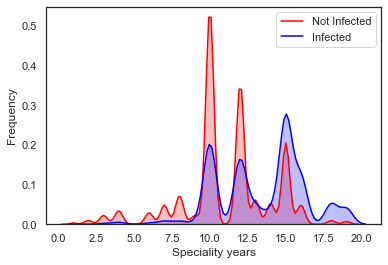

In [365]:
g = sns.kdeplot(data["speciality_years"][(data["target"] == 0) & (data["speciality_years"].notnull())], color="Red", shade = True)
g = sns.kdeplot(data["speciality_years"][(data["target"] == 1) & (data["speciality_years"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Speciality years")
g.set_ylabel("Frequency")
g = g.legend(["Not Infected","Infected"])

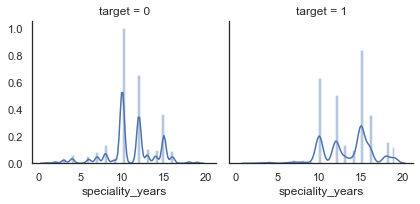

In [366]:
#same graph, but not superimposed
g = sns.FacetGrid(data, col='target')
g = g.map(sns.distplot, "speciality_years")

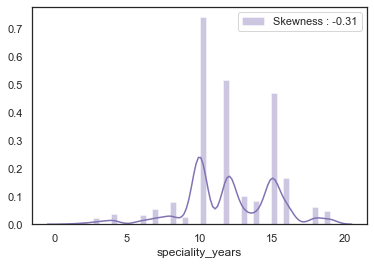

In [367]:
#skewness for the speciality years feature
g = sns.distplot(data["speciality_years"], color="m", label="Skewness : %.2f"%(data["speciality_years"].skew()))
g = g.legend(loc="best")

### Hours

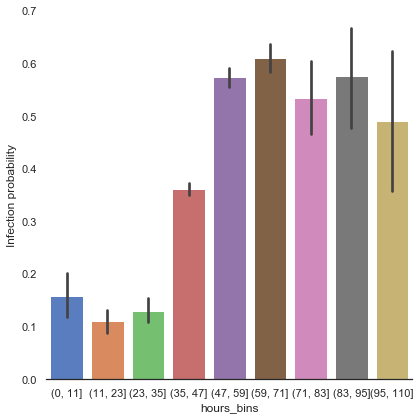

In [368]:
g = sns.factorplot(x="hours_bins",y="target",data=data,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("Infection probability")
#Higher values have higher standard deviation
#i divided the hours bins in intervals of 12 hours

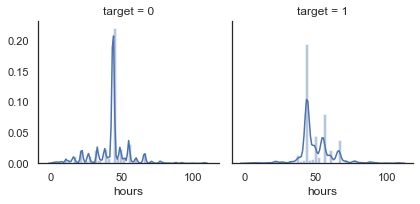

In [369]:
g = sns.FacetGrid(data, col='target')
g = g.map(sns.distplot, "hours")

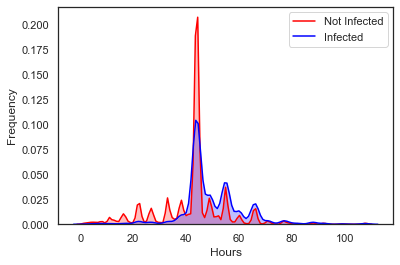

In [370]:
g = sns.kdeplot(data["hours"][(data["target"] == 0) & (data["hours"].notnull())], color="Red", shade = True)
g = sns.kdeplot(data["hours"][(data["target"] == 1) & (data["hours"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Hours")
g.set_ylabel("Frequency")
g = g.legend(["Not Infected","Infected"])

In [371]:
data["hours"].isnull().sum()

0

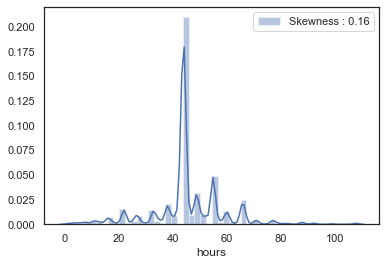

In [372]:
g = sns.distplot(data["hours"], label="Skewness : %.2f"%(data["hours"].skew()))
g = g.legend(loc="best")

### Multiple features analysis

C:\Users\Beatrice\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Beatrice\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


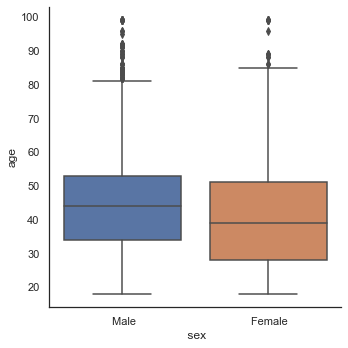

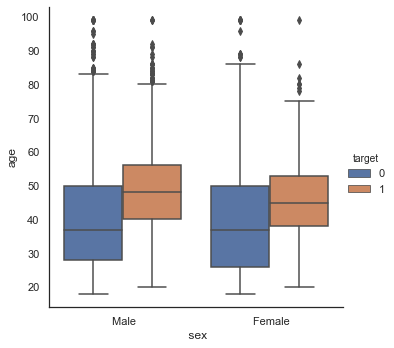

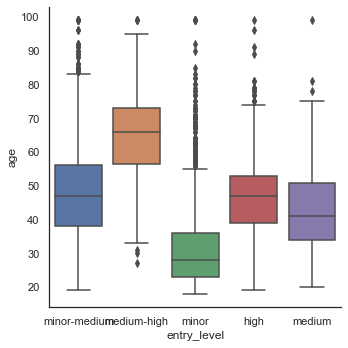

In [373]:
# Explore age vs sex,and entry level
g = sns.factorplot(y="age",x=" sex",data=data,kind="box")
g = sns.factorplot(y="age",x=" sex",hue="target", data=data,kind="box")
g = sns.factorplot(y="age",x="entry_level", data=data,kind="box")

## Categorical variables

### Speciality

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

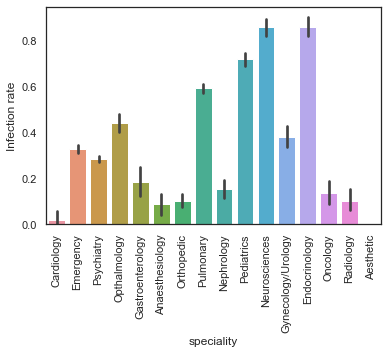

In [374]:
g = sns.barplot(x="speciality",y="target",data=data)
g = g.set_ylabel("Infection rate")

plt.xticks(rotation='vertical')

### Wing

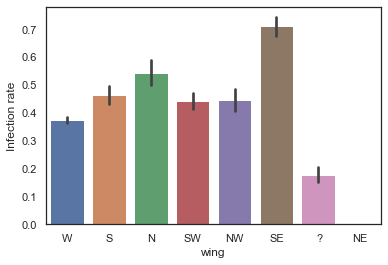

In [375]:
g = sns.barplot(x="wing",y="target",data=data)
g = g.set_ylabel("Infection rate")

#'?' probably refers to the East wing, which is absent here
#the data from east wing have probably been lost or corrupted

### Country

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

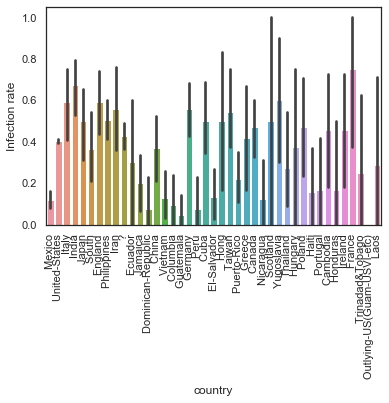

In [376]:
#the distribution seems to be more or less balanced
g = sns.barplot(x="country",y="target",data=data)
g = g.set_ylabel("Infection rate")
plt.xticks(rotation='vertical')

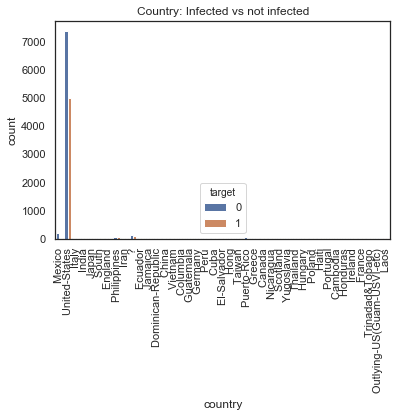

In [377]:
sns.countplot('country', hue='target', data=data)
plt.title('Country: Infected vs not infected')
plt.xticks(rotation='vertical')
plt.show()
#here we see that the majority of observations are from the US

### Occupation

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

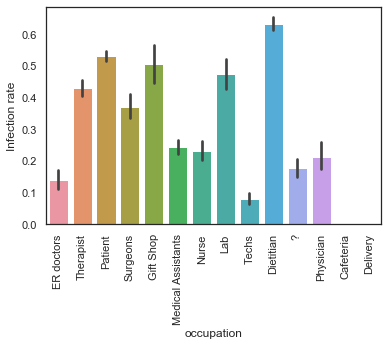

In [378]:
g = sns.barplot(x="occupation",y="target",data=data)
g = g.set_ylabel("Infection rate")

plt.xticks(rotation='vertical')
#many dietitians infected
#many gift shop clerks and patients infected

### Intervention

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

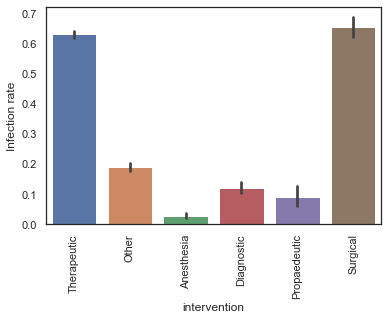

In [379]:
g = sns.barplot(x="intervention",y="target",data=data)
g = g.set_ylabel("Infection rate")

plt.xticks(rotation='vertical')

### Entry level

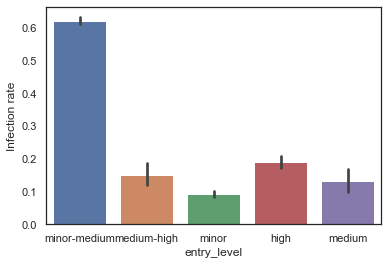

In [380]:
g = sns.barplot(x="entry_level",y="target",data=data)
g = g.set_ylabel("Infection rate")
# entry-level: 


In [438]:
###########
# I decided to label the entry level variable since it represents an ordinal categorical variable
entry={'minor-medium':2,'minor':1,'high':5,'medium-high':4,'medium':3}
data['entry_level']=data.entry_level.map(entry)

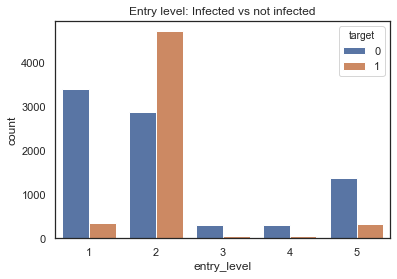

In [382]:
sns.countplot('entry_level', hue='target', data=data)
plt.title('Entry level: Infected vs not infected')
plt.show()

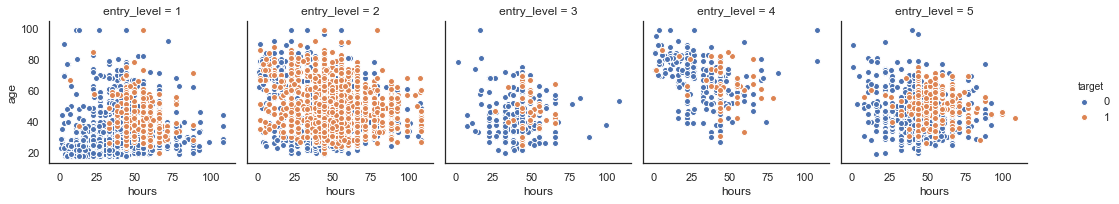

In [383]:
g = sns.FacetGrid(data, hue="target", col="entry_level", margin_titles=True,
                  )
g=g.map(plt.scatter, "hours", "age",edgecolor="w").add_legend();
#here we see that the vast majority of the people with a mild/medium condition are infected

### Ethnicity

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

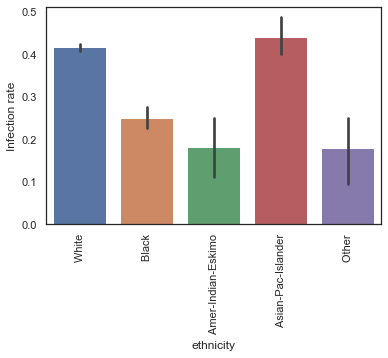

In [384]:
g = sns.barplot(x="ethnicity",y="target",data=data)
g = g.set_ylabel("Infection rate")
plt.xticks(rotation='vertical')

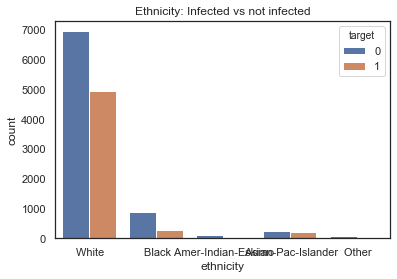

In [385]:
sns.countplot('ethnicity', hue='target', data=data)
plt.title('Ethnicity: Infected vs not infected')
plt.show()

### Sex

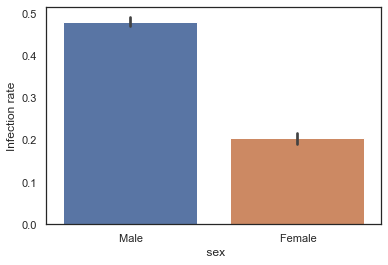

In [386]:
g = sns.barplot(x=" sex",y="target",data=data)
g = g.set_ylabel("Infection rate")


In [387]:
data[[' sex', 'target']].groupby([' sex'], as_index=False).mean().sort_values(by='target', ascending=False)

,sex,target
1,Male,0.481405
0,Female,0.204137


### Multiple feature analysis

C:\Users\Beatrice\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Beatrice\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


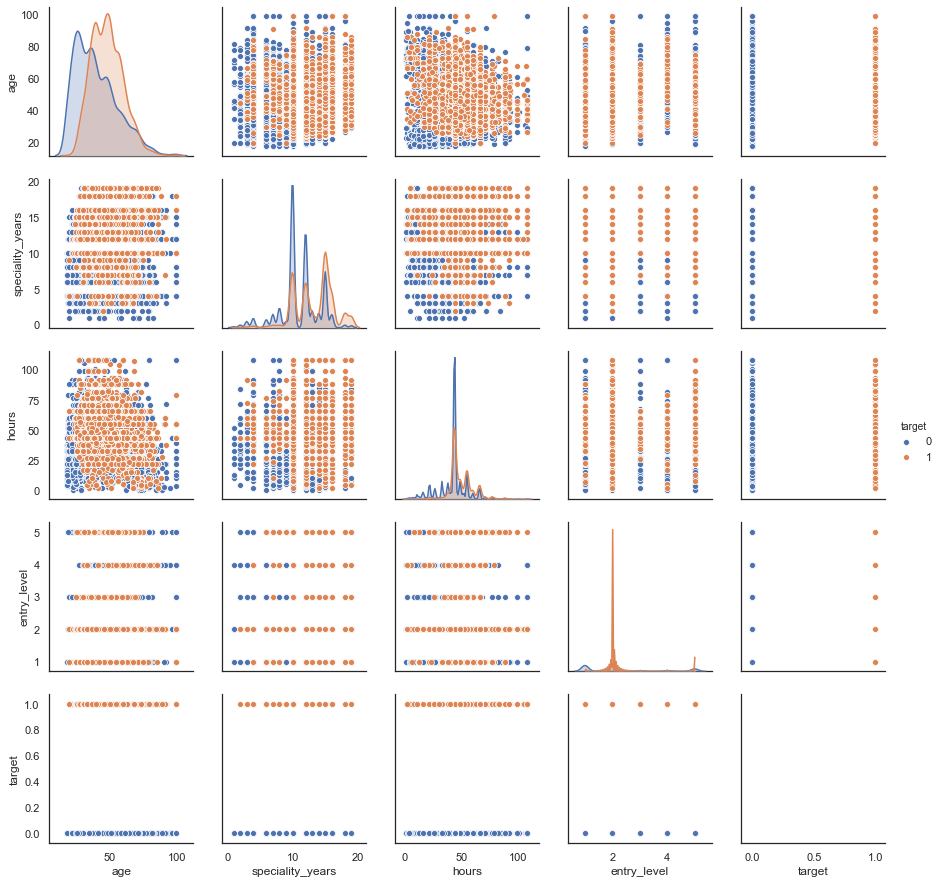

In [388]:
# Using seaborn pairplot to see the bivariate relation between each pair of features
sns.pairplot(data=data[["age","speciality_years","hours",'entry_level',"target"]],
             hue="target", dropna=True);

# Feature engineering

In [439]:
target=data['target']
target

0        0
1        1
2        0
3        1
4        1
        ..
13736    0
13737    1
13738    0
13739    0
13740    1
Name: target, Length: 13741, dtype: int64

In [440]:
country_code={' ?':'Other-country', ' Cambodia':'Other-country', ' Canada':'Other-country', ' China':'Other-country', ' Columbia':'Other-country', ' Cuba':'Other-country',
 ' Dominican-Republic':'Other-country', ' Ecuador':'Other-country', ' El-Salvador':'Other-country', ' England':'Other-country', ' France':'Other-country',
 ' Germany':'Other-country', ' Greece':'Other-country', ' Guatemala':'Other-country', ' Haiti':'Other-country', ' Honduras':'Other-country', ' Hong':'Other-country', ' Hungary':'Other-country',
 ' India':'Other-country', ' Iran':'Other-country', ' Ireland':'Other-country', ' Italy':'Other-country', ' Jamaica':'Other-country', ' Japan':'Other-country', ' Laos':'Other-country',
 ' Mexico':'Other-country', ' Nicaragua':'Other-country', ' Outlying-US(Guam-USVI-etc)':'Other-country', ' Peru':'Other-country',
 ' Philippines':'Other-country', ' Poland':'Other-country', ' Portugal':'Other-country', ' Puerto-Rico':'Other-country', ' Scotland':'Other-country', ' South':'Other-country',
 ' Taiwan':'Other-country', ' Thailand':'Other-country', ' Trinadad&Tobago':'Other-country', ' United-States':'USA', ' Vietnam':'Other-country',
 ' Yugoslavia':'Other-country'}
data['country']=data.country.map(country_code)
#12375 observations only for the US
#I decided to map it to a binary distribution

In [441]:
ethnicity_code={' White':'White', ' Black':'Black', ' Asian-Pac-Islander':'Asian-Pac-Islander', 
                ' Amer-Indian-Eskimo':'Amer-Indian-Eskimo', ' Other':'Other-ethnicity'
               }
data['ethnicity']=data.ethnicity.map(ethnicity_code)
#other-ethnicity so that when i get the dummy variables I can distinguish from Other-occupations

In [442]:
wing_code={' ?':'corrupted', 'W':'W', 'S':'S', 'SW':'SW',
                 'SE':'SE','N':'N','NW':'NW','NE':'NE'
       }
data['wing']=data.wing.map(wing_code)
occupation_code={' ?':'corrupted-data', 'Cafeteria':'Other-occupation', 'Delivery':'Other-occupation',
                 'Dietitian':'Dietitian', 'ER doctors':'ER doctors',
       'Gift Shop':'Gift shop', 'Lab':'Lab', 
                 'Medical Assistants':'Medical Assistant',
                 'Nurse':'Nurse', 'Patient':'Patient',
       'Physician':'Physician', 'Surgeons':'Surgeons', 
                 'Techs':'Techs', 'Therapist':'Therapist'}
data['occupation']=data.occupation.map(occupation_code)
#i put cafeteria and delivery into other-occupations because they have very few instances
#I also considered puting gift shop into other occupations
#but a lot of gist shop clerks were infected

In [443]:
data['age_bins'] = pd.cut(x=data['age'], bins=[10,19, 29, 39, 49,59,69,79,89,99])
data['hours_bins'] = pd.cut(x=data['hours'], bins=[0,11,23,35,47,59,71,83,95,110])
data['years_bins'] = pd.cut(x=data['speciality_years'], bins=[0,4,9,14,19])

In [444]:
data.drop('age',1,inplace=True)
data.drop('hours',1,inplace=True)
data.drop('speciality_years',1,inplace=True)

In [445]:
dummy = pd.get_dummies(data['country'],drop_first=True) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("country", 1)
data.head()

,speciality,wing,entry_level,occupation,intervention,ethnicity,sex,target,age_bins,hours_bins,years_bins,USA
0,Cardiology,W,2,ER doctors,Therapeutic,White,Male,0,"(29, 39]","(35, 47]","(0, 4]",0
1,Emergency,W,2,Therapist,Therapeutic,White,Male,1,"(49, 59]","(47, 59]","(9, 14]",1
2,Psychiatry,S,4,Patient,Other,Black,Male,0,"(59, 69]","(35, 47]","(9, 14]",1
3,Emergency,W,2,Patient,Therapeutic,Black,Male,1,"(59, 69]","(47, 59]","(9, 14]",1
4,Psychiatry,W,2,Surgeons,Therapeutic,White,Male,1,"(29, 39]","(71, 83]","(9, 14]",1


In [446]:
dummy = pd.get_dummies(data[' sex'],drop_first=True) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop(" sex", 1)
data.head()

,speciality,wing,entry_level,occupation,intervention,ethnicity,target,age_bins,hours_bins,years_bins,USA,Male
0,Cardiology,W,2,ER doctors,Therapeutic,White,0,"(29, 39]","(35, 47]","(0, 4]",0,1
1,Emergency,W,2,Therapist,Therapeutic,White,1,"(49, 59]","(47, 59]","(9, 14]",1,1
2,Psychiatry,S,4,Patient,Other,Black,0,"(59, 69]","(35, 47]","(9, 14]",1,1
3,Emergency,W,2,Patient,Therapeutic,Black,1,"(59, 69]","(47, 59]","(9, 14]",1,1
4,Psychiatry,W,2,Surgeons,Therapeutic,White,1,"(29, 39]","(71, 83]","(9, 14]",1,1


In [447]:

data=data.drop("target", 1)
data.head()

,speciality,wing,entry_level,occupation,intervention,ethnicity,age_bins,hours_bins,years_bins,USA,Male
0,Cardiology,W,2,ER doctors,Therapeutic,White,"(29, 39]","(35, 47]","(0, 4]",0,1
1,Emergency,W,2,Therapist,Therapeutic,White,"(49, 59]","(47, 59]","(9, 14]",1,1
2,Psychiatry,S,4,Patient,Other,Black,"(59, 69]","(35, 47]","(9, 14]",1,1
3,Emergency,W,2,Patient,Therapeutic,Black,"(59, 69]","(47, 59]","(9, 14]",1,1
4,Psychiatry,W,2,Surgeons,Therapeutic,White,"(29, 39]","(71, 83]","(9, 14]",1,1


In [448]:
dummy = pd.get_dummies(data['ethnicity']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("ethnicity", 1)
data.head()

,speciality,wing,entry_level,occupation,intervention,age_bins,hours_bins,years_bins,USA,Male,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other-ethnicity,White
0,Cardiology,W,2,ER doctors,Therapeutic,"(29, 39]","(35, 47]","(0, 4]",0,1,0,0,0,0,1
1,Emergency,W,2,Therapist,Therapeutic,"(49, 59]","(47, 59]","(9, 14]",1,1,0,0,0,0,1
2,Psychiatry,S,4,Patient,Other,"(59, 69]","(35, 47]","(9, 14]",1,1,0,0,1,0,0
3,Emergency,W,2,Patient,Therapeutic,"(59, 69]","(47, 59]","(9, 14]",1,1,0,0,1,0,0
4,Psychiatry,W,2,Surgeons,Therapeutic,"(29, 39]","(71, 83]","(9, 14]",1,1,0,0,0,0,1


In [449]:
dummy = pd.get_dummies(data['occupation']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("occupation", 1)
data.head()

,speciality,wing,entry_level,intervention,age_bins,hours_bins,years_bins,USA,Male,Amer-Indian-Eskimo,...,Lab,Medical Assistant,Nurse,Other-occupation,Patient,Physician,Surgeons,Techs,Therapist,corrupted-data
0,Cardiology,W,2,Therapeutic,"(29, 39]","(35, 47]","(0, 4]",0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Emergency,W,2,Therapeutic,"(49, 59]","(47, 59]","(9, 14]",1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,Psychiatry,S,4,Other,"(59, 69]","(35, 47]","(9, 14]",1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,Emergency,W,2,Therapeutic,"(59, 69]","(47, 59]","(9, 14]",1,1,0,...,0,0,0,0,1,0,0,0,0,0
4,Psychiatry,W,2,Therapeutic,"(29, 39]","(71, 83]","(9, 14]",1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [450]:
dummy = pd.get_dummies(data['intervention']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("intervention", 1)
data.head()

,speciality,wing,entry_level,age_bins,hours_bins,years_bins,USA,Male,Amer-Indian-Eskimo,Asian-Pac-Islander,...,Surgeons,Techs,Therapist,corrupted-data,Anesthesia,Diagnostic,Other,Propaedeutic,Surgical,Therapeutic
0,Cardiology,W,2,"(29, 39]","(35, 47]","(0, 4]",0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Emergency,W,2,"(49, 59]","(47, 59]","(9, 14]",1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Psychiatry,S,4,"(59, 69]","(35, 47]","(9, 14]",1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Emergency,W,2,"(59, 69]","(47, 59]","(9, 14]",1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Psychiatry,W,2,"(29, 39]","(71, 83]","(9, 14]",1,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [451]:
dummy = pd.get_dummies(data['speciality']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("speciality", 1)
data.head()

,wing,entry_level,age_bins,hours_bins,years_bins,USA,Male,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,...,Gynecology/Urology,Nephrology,Neurosciences,Oncology,Opthalmology,Orthopedic,Pediatrics,Psychiatry,Pulmonary,Radiology
0,W,2,"(29, 39]","(35, 47]","(0, 4]",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,W,2,"(49, 59]","(47, 59]","(9, 14]",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,S,4,"(59, 69]","(35, 47]","(9, 14]",1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,W,2,"(59, 69]","(47, 59]","(9, 14]",1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,W,2,"(29, 39]","(71, 83]","(9, 14]",1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [452]:
dummy = pd.get_dummies(data['wing']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("wing", 1)
data.head()

,entry_level,age_bins,hours_bins,years_bins,USA,Male,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other-ethnicity,...,Pulmonary,Radiology,N,NE,NW,S,SE,SW,W,corrupted
0,2,"(29, 39]","(35, 47]","(0, 4]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,"(49, 59]","(47, 59]","(9, 14]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4,"(59, 69]","(35, 47]","(9, 14]",1,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,2,"(59, 69]","(47, 59]","(9, 14]",1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2,"(29, 39]","(71, 83]","(9, 14]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [453]:
data.drop('corrupted',1, inplace=True)
#so i only have 1 column representing the corrupted data pertaining to the east wing

In [454]:
dummy = pd.get_dummies(data['age_bins']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("age_bins", 1)
dummy = pd.get_dummies(data['hours_bins']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("hours_bins", 1)
dummy = pd.get_dummies(data['years_bins']) 
data = pd.concat([data,dummy], axis = 1)
data=data.drop("years_bins", 1)
data.head()

,entry_level,USA,Male,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other-ethnicity,White,Dietitian,ER doctors,...,"(35, 47]","(47, 59]","(59, 71]","(71, 83]","(83, 95]","(95, 110]","(0, 4]","(4, 9]","(9, 14]","(14, 19]"
0,2,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,4,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,2,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,2,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [455]:
data.columns

Index([       'entry_level',                'USA',              ' Male',
       'Amer-Indian-Eskimo', 'Asian-Pac-Islander',              'Black',
          'Other-ethnicity',              'White',          'Dietitian',
               'ER doctors',          'Gift shop',                'Lab',
        'Medical Assistant',              'Nurse',   'Other-occupation',
                  'Patient',          'Physician',           'Surgeons',
                    'Techs',          'Therapist',     'corrupted-data',
               'Anesthesia',         'Diagnostic',              'Other',
             'Propaedeutic',           'Surgical',        'Therapeutic',
                'Aesthetic',    'Anaesthesiology',         'Cardiology',
                'Emergency',      'Endocrinology',   'Gastroenterology',
       'Gynecology/Urology',         'Nephrology',      'Neurosciences',
                 'Oncology',       'Opthalmology',         'Orthopedic',
               'Pediatrics',         'Psychiatry', 

In [458]:
#(yes, again) because I hope I've mapped everything correctly
data.isnull().sum()

entry_level           0
USA                   0
 Male                 0
Amer-Indian-Eskimo    0
Asian-Pac-Islander    0
                     ..
(95, 110]             0
(0, 4]                0
(4, 9]                0
(9, 14]               0
(14, 19]              0
Length: 72, dtype: int64

In [457]:
data= data.astype(int)
X=data
y=target.astype(int)

In [459]:
print(X.columns)
X.head()

Index([       'entry_level',                'USA',              ' Male',
       'Amer-Indian-Eskimo', 'Asian-Pac-Islander',              'Black',
          'Other-ethnicity',              'White',          'Dietitian',
               'ER doctors',          'Gift shop',                'Lab',
        'Medical Assistant',              'Nurse',   'Other-occupation',
                  'Patient',          'Physician',           'Surgeons',
                    'Techs',          'Therapist',     'corrupted-data',
               'Anesthesia',         'Diagnostic',              'Other',
             'Propaedeutic',           'Surgical',        'Therapeutic',
                'Aesthetic',    'Anaesthesiology',         'Cardiology',
                'Emergency',      'Endocrinology',   'Gastroenterology',
       'Gynecology/Urology',         'Nephrology',      'Neurosciences',
                 'Oncology',       'Opthalmology',         'Orthopedic',
               'Pediatrics',         'Psychiatry', 

,entry_level,USA,Male,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other-ethnicity,White,Dietitian,ER doctors,...,"(35, 47]","(47, 59]","(59, 71]","(71, 83]","(83, 95]","(95, 110]","(0, 4]","(4, 9]","(9, 14]","(14, 19]"
0,2,0,1,0,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,4,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,2,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,2,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [460]:
y

0        0
1        1
2        0
3        1
4        1
        ..
13736    0
13737    1
13738    0
13739    0
13740    1
Name: target, Length: 13741, dtype: int32

In [461]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.30,
                                                    stratify=y,
                                                    random_state= 123)

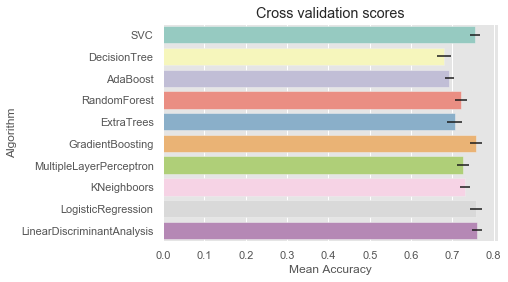

In [462]:
#comparing some classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 123
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "f1", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [463]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',C=1, class_weight="balanced")
#put class_weight='balanced' because the data is slightly imbalanced (about 40%-60% rate)

In [464]:
model.fit(X_train, y_train)
model.predict(X_test)

C:\Users\Beatrice\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0, 1, 0, ..., 0, 1, 0])

In [465]:
#defining classifier and parameters
from sklearn.svm import SVC

classifier = SVC()
parameters = {"kernel":['linear','rbf'], "C":[0.01,0.1,10],"gamma":[1e-4,1e-3,0.01,1]}

In [466]:
#Gridsearch for the estimator

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=kfold, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)

In [467]:
gs = gs.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.8min
[Paralle

In [468]:
print('***GRIDSEARCH RESULTS***')

print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

***GRIDSEARCH RESULTS***
Best score: 0.762516 using {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.749360 (0.012909) with: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.749360 (0.012909) with: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.749360 (0.012909) with: {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.749360 (0.012909) with: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
0.755055 (0.013769) with: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.755055 (0.013769) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.755055 (0.013769) with: {'C': 0.1, 'gamma': 

In [469]:
#TEST
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
#prediction evaluation
from sklearn.metrics import f1_score
print('***RESULTS ON TRAIN SET***')
print("f1_score: ", gs.best_score_)
print('***RESULTS ON TEST SET***')
print("f1_score: ", metrics.f1_score(y_test, y_pred))

***RESULTS ON TRAIN SET***
f1_score:  0.7625161054351112
***RESULTS ON TEST SET***
f1_score:  0.7678467788740568


In [470]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[2000  476]
 [ 324 1323]]


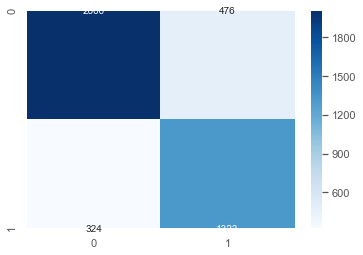

In [471]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); 

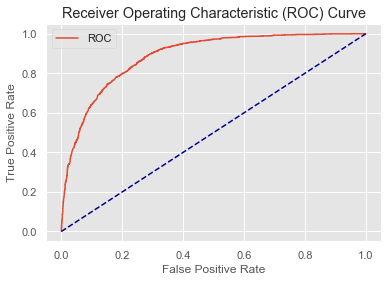

AUC: 0.89


In [474]:
from sklearn import metrics

model = SVC(C=10, gamma=0.001, kernel='rbf',probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test) 
fpr, tpr, thresholds=metrics.roc_curve(y_test,  y_probs[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc = metrics.roc_auc_score(y_test, y_probs[:,1])
print('AUC: %.2f' % auc)